In [1]:
import pickle
import numpy as np
import csv
from collections import OrderedDict
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import copy
import tables

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import sklearn
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [2]:
def getDateSlash(string):
    '''
    Give back year, month, day of a given data string
    '''
    nums = string.split('/')
    #print(nums,string)    
    if int(nums[2]) < 17:
        nums[2] = int(nums[2]) + 2000
    else:
        nums[2] = int(nums[2]) + 1900
    return int(nums[1]),int(nums[0]),int(nums[2])

In [3]:
def getDateDash(string):
    '''
    Give back year, month, day of a given data string
    '''
    nums = string.split('-')
    #print(nums,string)    

    return int(nums[0]),int(nums[1]),int(nums[2])

In [4]:
def dateToString(d,m,y):
    '''
    Convert day, month, and year values to a string with format DD-MM-YYYY
    '''
    return "-".join([str(d),str(m),str(y)])

In [5]:
def stringToDays(string):
    '''
    Give back date in days since 01.01.1900 given data string
    '''
    return (datetime.datetime(getDateDash(string)[2],getDateDash(string)[1],getDateDash(string)[0]) - datetime.datetime(1900,1,1)).days + 1

In [6]:
'''
Create dictionaries of headlines, texts and relevance values in economy data set
'''
news_h = {}
news_t = {}
new_target = {}
with open('Full-Economic-News.csv','rU') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for i,row in enumerate(reader):
        if i > 0:
            current_date = dateToString(getDateSlash(row[10])[0],getDateSlash(row[10])[1],getDateSlash(row[10])[2])
            if current_date in news_h:
                current_list_h = news_h[current_date]
                current_list_h.append(row[11])
                news_h[current_date] = current_list_h

                current_list_t = news_t[current_date]
                current_list_t.append(row[14])
                news_t[current_date] = current_list_t
                
                current_list_target = new_target[current_date]
                current_list_target.append(row[7])
                new_target[current_date] = current_list_target
            else:
                news_h[current_date] = [row[11]]
                news_t[current_date] = [row[14]]
                new_target[current_date] = [row[7]]
                
            
# dictionary sorted by key
news_h_ord = OrderedDict(sorted(news_h.items(), key=lambda t: stringToDays(t[0])))
news_t_ord = OrderedDict(sorted(news_t.items(), key=lambda t: stringToDays(t[0])))
new_target_ord = OrderedDict(sorted(new_target.items(), key=lambda t: stringToDays(t[0])))

In [7]:
'''
Create dictionary with all DJIA values since 1985
'''
djia = {}
with open('DJI_1985.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for i,row in enumerate(reader):
        if i > 0:
            current_date = dateToString(getDateDash(row[0])[2],getDateDash(row[0])[1],getDateDash(row[0])[0])
            djia[current_date] = [float(elem) for elem in row[1:]]


# dictionary sorted by key
djia_ord = OrderedDict(sorted(djia.items(), key=lambda t: stringToDays(t[0])))

In [1]:
'''
Create big dictionary with all information combined
Sorts our non-overlapping dates from DIJA dict
'''
change = {}

keys = list(djia_ord.keys())
for i,entry in enumerate(djia_ord):
    if entry in news_h_ord:
        if i > 0 and i < len(djia_ord)-1:
            yesterday = djia_ord[keys[i-1]][5]-djia_ord[keys[i]][5]
            tomorrow = djia_ord[keys[i]][5]-djia_ord[keys[i+1]][5]
            y_change = yesterday >= 0
            t_change = tomorrow >= 0
            # 0: relevance value to US economy
            # 1: change in comp to yesterday
            # 2: change in comp to yesterday (bool)
            # 3: change in comp to tomorrow
            # 4: change in comp to tomorrow (bool)
            # 5: list of newsheadings
            # 6: list of news texts
            # 7: yesterday's value
            # 8: today's value
            # 9: tomorrows's value
            change[entry] = [new_target_ord[entry], yesterday, y_change, tomorrow, t_change, news_h_ord[entry], news_t_ord[entry], djia_ord[keys[i-1]][5],djia_ord[keys[i]][5],djia_ord[keys[i+1]][5]]

# dictionary sorted by key
change_ord = OrderedDict(sorted(change.items(), key=lambda t: stringToDays(t[0])))

NameError: name 'djia_ord' is not defined

In [9]:
# Number of entries
print(len(change_ord))

3696

In [9]:
# Create list with only the target value
data_target = []
for entry in change_ord:
    data_target.append(change_ord[entry][4])

In [10]:
# Create lists with training data and target data
data_new_t = []
data_new_h = []
target_new = []
for i,entry in enumerate(change_ord):
    string = change_ord[entry][5]
    string2 = change_ord[entry][6]
    target = change_ord[entry][4]
    data_new_h.append(string)
    data_new_t.append(string2)
    target_new.append(target)
    
## Use if relevance is target to convert string to boolean
#  for j,t in enumerate(target):
#     data_new_h.append(string[j])
#     data_new_t.append(string2[j])
#     if target[j] == 'no':
#         target_new.append(0)
#     else:
#         target_new.append(1)

In [12]:
# Check if we lost entries in between --> nope
print(len(data_new_t))

3696

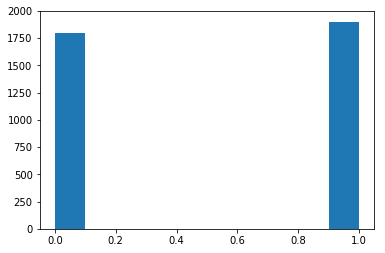

In [13]:
# Plot target value distribution
plt.hist(target_new)
plt.show()

In [20]:
# Print ratios
print("Positive",float(np.sum(target_new))/float(len(target_new)))
print("Negative",float(len(target_new)-np.sum(target_new))/float(len(target_new)))

('Positive', 0.5143398268398268)
('Negative', 0.4856601731601732)


In [19]:
# Convert target to integer
data_target = [int(x) for x in data_target]

In [11]:
# And yet another chance to create some lists
data_h = []
for i,entry in enumerate(change_ord):
    string = change_ord[entry][5]
    data_h.append(string)

In [12]:
data_t = []
for i,entry in enumerate(change_ord):
    string = change_ord[entry][6]
    data_t.append(string)

# Character wise integer encoding

In [13]:
# Join all headings of one day in order to obtain dictionary later
all_days_h = []
for l in data_h:
    one_day = ' '.join(l)
    all_days_h.append(one_day)

In [14]:
# Join all texts of one day
all_days_t = []
for l in data_t:
    one_day = ' '.join(l)
    all_days_t.append(one_day)

In [42]:
# Overall join of headings
joined_h = ' '.join(all_days_h)

In [43]:
# Overall join of texts
joined_t = ' '.join(all_days_t)

In [44]:
# Join headings and texts
l = [joined_h, joined_t]
words = ' '.join(l)

In [46]:
# Delete special characters and make buffer punctuation (more important for word wise encoding)
words = words.replace('\n',' ')
words = words.replace('\t',' ')
words = words.replace('b\'','')
words = words.replace('b"','')
words = words.replace('b\\','')
words = words.replace('\\xa3','')
words = words.replace('\\xc7','')
words = words.replace('\\xcf','')
words = words.replace('\\xd3','')
words = words.replace('\\xdb','')
words = words.replace('\\xe3','')
words = words.replace('\\xf7','')
words = words.replace('\\xa4','')
words = words.replace('\\xa8','')
words = words.replace('\\x9d','')
words = words.replace('\\xa9','')
words = words.replace('\\xb1','')
words = words.replace('\\xe5','')
words = words.replace('\\xc8','')
words = words.replace('\\xcc','')
words = words.replace('\\xd0','')
words = words.replace('\\x81','')
words = words.replace('\\x89','')
words = words.replace('\\xa2','')
words = words.replace('\\xaa','')
words = words.replace('\\xca','')
words = words.replace('.',' . ')
words = words.replace(',',' , ')
words = words.replace(':',' : ')
words = words.replace(';',' ; ')
words = words.replace('"',' " ')
words = words.replace(')',' ) ')
words = words.replace('(',' ( ')
words = words.replace('#',' # ')
words = words.replace('?',' ? ')
words = words.replace('!',' ! ')
words = words.replace('&',' & ')
words = words.replace('/',' / ')
words = words.replace('+',' + ')
words = words.replace('‚',' ‚ ')
words = words.replace('”',' ” ')
words = words.replace('“',' “ ')

In [15]:
def replace_special_chars(words):
    '''
    Deletes special characters and makes buffer punctuation
    '''
    words = words.replace('\n',' ')
    words = words.replace('\t',' ')
    words = words.replace('b\'','')
    words = words.replace('b"','')
    words = words.replace('b\\','')
    words = words.replace('\\xa3','')
    words = words.replace('\\xc7','')
    words = words.replace('\\xcf','')
    words = words.replace('\\xd3','')
    words = words.replace('\\xdb','')
    words = words.replace('\\xe3','')
    words = words.replace('\\xf7','')
    words = words.replace('\\xa4','')
    words = words.replace('\\xa8','')
    words = words.replace('\\x9d','')
    words = words.replace('\\xa9','')
    words = words.replace('\\xb1','')
    words = words.replace('\\xe5','')
    words = words.replace('\\xc8','')
    words = words.replace('\\xcc','')
    words = words.replace('\\xd0','')
    words = words.replace('\\x81','')
    words = words.replace('\\x89','')
    words = words.replace('\\xa2','')
    words = words.replace('\\xaa','')
    words = words.replace('\\xca','')
    words = words.replace('.',' . ')
    words = words.replace(',',' , ')
    words = words.replace(':',' : ')
    words = words.replace(';',' ; ')
    words = words.replace('"',' " ')
    words = words.replace(')',' ) ')
    words = words.replace('(',' ( ')
    words = words.replace('#',' # ')
    words = words.replace('?',' ? ')
    words = words.replace('!',' ! ')
    words = words.replace('&',' & ')
    words = words.replace('/',' / ')
    words = words.replace('+',' + ')
    words = words.replace('‚',' ‚ ')
    words = words.replace('”',' ” ')
    words = words.replace('“',' “ ')
    return words

In [48]:
# Create character encoding dictionary
chars = sorted(list(set(words)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [50]:
print(char_to_int.keys())
print(sorted(int_to_char.keys()))

[' ', '\xa3', '$', '(', ',', '0', '4', '8', '<', '@', 'D', '\xc7', 'H', 'L', '\xcf', 'P', '\xd3', 'T', 'X', '\xdb', '\\', '`', '\xe3', 'd', 'h', 'l', 'p', 't', '\xf7', 'x', '|', '#', '\xa4', "'", '\xa8', '+', '/', '3', '7', ';', '?', 'C', 'G', '\xc8', 'K', '\xcc', 'O', '\xd0', 'S', 'W', '[', '_', 'c', 'g', 'k', 'o', 's', 'w', '{', '\x81', '\x89', '\x9d', '"', '&', '\xa9', '*', '.', '\xb1', '2', '6', ':', '>', 'B', 'F', 'J', 'N', 'R', 'V', 'Z', '^', 'b', '\xe5', 'f', 'j', 'n', 'r', 'v', 'z', '~', '!', '\xa2', '%', ')', '\xaa', '-', '1', '5', '9', '=', 'A', 'E', 'I', '\xca', 'M', 'Q', 'U', 'Y', ']', 'a', 'e', 'i', 'm', 'q', 'u', 'y', '}']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 

In [11]:
# # Load character encoding dictionary
# char_to_int = pickle.load(open('char_to_int.pkl','rb'))
# int_to_char = pickle.load(open('int_to_char.pkl','rb'))

In [96]:
# # Save character encoding dictionary
# pickle.dump(char_to_int,open('char_to_int.pkl','wb'))
# pickle.dump(int_to_char,open('int_to_char.pkl','wb'))

# Vectorized

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [18]:
# Make characters uniced (needed for vectorizer)
train_list_final = []
for i,entry in enumerate(data_new_h):
    one_day = ' '.join(entry)
    s = unicode(replace_special_chars(one_day), errors='replace')
    train_list_final.append(s)

In [31]:
# Apply TF IDF Vectorizer
advancedvectorizer = TfidfVectorizer( min_df=0.01, max_df=0.99, max_features = 200000, ngram_range = (1, 3))
advancedtrain = advancedvectorizer.fit_transform(train_list_final)

In [34]:
# Check lenght of encoding
X_all = advancedtrain.toarray()

print('X_all shape:', X_all.shape)

('X_all shape:', (3696, 258))


In [35]:
# Split into train - val - test set (data)
train_h, validate_h, test_h = np.split(X_all, [int(.8*len(X_all)), int(.9*len(X_all))])

In [39]:
# Split into train - val - test set (target)
y_train_h, y_validate_h, y_test_h = np.split(data_target, [int(.8*len(X_all)), int(.9*len(X_all))])

In [40]:
# Check how big splits are
print(len(train_h))
print(len(validate_h))
print(len(test_h))
print(len(y_train_h))
print(len(y_validate_h))
print(len(y_test_h))

2956
370
370
2956
370
370


In [45]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_train_h = train_h.reshape(len(train_h), 258, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_train_h = y_train_h.reshape(len(y_train_h), 1)

In [47]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_test_h = test_h.reshape(len(test_h), 258, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_test_h = y_test_h.reshape(len(y_test_h), 1)

In [50]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_val_h = validate_h.reshape(len(validate_h), 258, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_val_h = y_validate_h.reshape(len(y_validate_h), 1)

In [51]:
print(X_train_h.shape)
print(y_train_h.shape)
print(X_val_h.shape)
print(y_val_h.shape)
print(X_test_h.shape)
print(y_test_h.shape)

(2956, 258, 1)
(2956, 1)
(370, 258, 1)
(370, 1)
(370, 258, 1)
(370, 1)


In [52]:
pickle.dump(X_val_h,open('X_val_h_tfidf.pkl','wb'))
pickle.dump(y_val_h,open('y_val_h_tfidf.pkl','wb'))

In [53]:
pickle.dump(X_test_h,open('X_test_h_tfidf.pkl','wb'))
pickle.dump(y_test_h,open('y_test_h_tfidf.pkl','wb'))

In [54]:
pickle.dump(X_train_h,open('X_train_h_tfidf.pkl','wb'))
pickle.dump(y_train_h,open('y_train_h_tfidf.pkl','wb'))

# Tokenized

In [63]:
from keras.preprocessing.text import Tokenizer
max_features = 10000
EMBEDDING_DIM = 100
maxlen = 200
batch_size = 32

In [65]:
import keras.preprocessing.text

# Keras had a bug, this was the solution (copying src code with little variaten)
def text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True, split=" "):
    if lower: text = text.lower()
    if type(text) == unicode:
        translate_table = {ord(c): ord(t) for c,t in zip(filters, split*len(filters)) }
    else:
        translate_table = maketrans(filters, split * len(filters))
    text = text.translate(translate_table)
    seq = text.split(split)
    return [i for i in seq if i]
    
keras.preprocessing.text.text_to_word_sequence = text_to_word_sequence

In [66]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=max_features)
tokenizer.fit_on_texts(train_list_final)
sequences_train = tokenizer.texts_to_sequences(train_list_final)

In [67]:
print('Pad sequences (samples x time)')
X_all = sequence.pad_sequences(sequences_train, maxlen=maxlen)

Pad sequences (samples x time)


In [68]:
# Check length of encoding
X_all.shape

(3696, 200)

In [74]:
# Split into train - val - test set (data)
train_h, validate_h, test_h = np.split(X_all, [int(.8*len(X_all)), int(.9*len(X_all))])

In [75]:
# Split into train - val - test set (target)
y_train_h, y_validate_h, y_test_h = np.split(data_target, [int(.8*len(X_all)), int(.9*len(X_all))])

In [76]:
print(len(train_h))
print(len(validate_h))
print(len(test_h))
print(len(y_train_h))
print(len(y_validate_h))
print(len(y_test_h))

2956
370
370
2956
370
370


In [78]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_train_h = train_h.reshape(len(train_h), 200, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_train_h = y_train_h.reshape(len(y_train_h), 1)

In [79]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_test_h = test_h.reshape(len(test_h), 200, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_test_h = y_test_h.reshape(len(y_test_h), 1)

In [80]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_val_h = validate_h.reshape(len(validate_h), 200, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_val_h = y_validate_h.reshape(len(y_validate_h), 1)

In [81]:
print(X_train_h.shape)
print(y_train_h.shape)
print(X_val_h.shape)
print(y_val_h.shape)
print(X_test_h.shape)
print(y_test_h.shape)

(2956, 200, 1)
(2956, 1)
(370, 200, 1)
(370, 1)
(370, 200, 1)
(370, 1)


In [82]:
pickle.dump(X_val_h,open('X_val_h_token.pkl','wb'))
pickle.dump(y_val_h,open('y_val_h_token.pkl','wb'))

In [83]:
pickle.dump(X_test_h,open('X_test_h_token.pkl','wb'))
pickle.dump(y_test_h,open('y_test_h_token.pkl','wb'))

In [84]:
pickle.dump(X_train_h,open('X_train_h_token.pkl','wb'))
pickle.dump(y_train_h,open('y_train_h_token.pkl','wb'))

# Continuation char to int

In [ ]:
# Making pandas dataframe first but then saving similar to what is done above...

In [61]:
int_news_h = pd.DataFrame(np.zeros((len(data_new_h),694)))
for i,n in enumerate(data_new_h):
    n = replace_special_chars(n)
    chars = list(n)
    fill = ([char_to_int[c] for c in chars])
    for j in range(len(fill),694):
        fill.append(0)
    int_news_h.iloc[i,:] = fill

In [62]:
int_news_t = pd.DataFrame(np.zeros((len(data_new_t),10331)))
for i,n in enumerate(data_new_t):
    n = replace_special_chars(n)
    chars = list(n)
    fill = ([char_to_int[c] for c in chars])
    for j in range(len(fill),10331):
        fill.append(0)
    int_news_t.iloc[i,:] = fill

In [75]:
len(target_new)

5206

In [69]:
int_news_t['target'] = pd.DataFrame(np.array(target_new), index=int_news_t.index)

In [70]:
int_news_h['target'] = pd.DataFrame(np.array(target_new), index=int_news_h.index)

In [71]:
store = pd.HDFStore('int_news_new_target.h5')
store['int_news_h'] = int_news_h  # save it
store['int_news_t'] = int_news_t  # save it
store.close()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  app.launch_new_instance()


In [72]:
train_h, validate_h, test_h = np.split(int_news_h, [int(.8*len(int_news_h)), int(.9*len(int_news_h))])

In [73]:
train_t, validate_t, test_t = np.split(int_news_t, [int(.8*len(int_news_t)), int(.9*len(int_news_t))])

In [74]:
print(len(train_h))
print(len(validate_h))
print(len(test_h))

4164
521
521


In [76]:
train_h

,0,1,2,3,4,5,6,7,8,9,...,685,686,687,688,689,690,691,692,693,target
0,50.0,37.0,54.0,41.0,37.0,55.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,57.0,73.0,69.0,76.0,68.0,83.0,0.0,79.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,52.0,72.0,69.0,0.0,47.0,85.0,84.0,76.0,79.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,47.0,78.0,76.0,89.0,0.0,55.0,65.0,89.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,50.0,69.0,76.0,89.0,73.0,78.0,71.0,0.0,79.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,35.0,72.0,69.0,77.0,73.0,67.0,65.0,76.0,0.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,41.0,78.0,67.0,79.0,77.0,69.0,0.0,50.0,73.0,83.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,37.0,67.0,79.0,78.0,79.0,77.0,89.0,0.0,48.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,33.0,77.0,69.0,82.0,73.0,67.0,65.0,78.0,0.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,37.0,67.0,79.0,78.0,79.0,77.0,73.0,83.0,84.0,83.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [77]:
validate_h

,0,1,2,3,4,5,6,7,8,9,...,685,686,687,688,689,690,691,692,693,target
4164,34.0,69.0,82.0,78.0,65.0,78.0,75.0,69.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4165,39.0,37.0,0.0,84.0,79.0,0.0,37.0,78.0,68.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4166,40.0,69.0,65.0,82.0,68.0,0.0,79.0,78.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4167,53.0,0.0,14.0,0.0,51.0,0.0,14.0,0.0,0.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4168,52.0,82.0,69.0,65.0,83.0,85.0,82.0,89.0,83.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4169,38.0,79.0,82.0,0.0,84.0,72.0,69.0,0.0,38.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4170,45.0,65.0,71.0,85.0,73.0,82.0,69.0,0.0,55.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4171,33.0,72.0,69.0,65.0,68.0,0.0,79.0,70.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4172,53.0,78.0,69.0,77.0,80.0,76.0,79.0,89.0,77.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4173,51.0,69.0,65.0,82.0,83.0,0.0,48.0,79.0,83.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [78]:
test_h

,0,1,2,3,4,5,6,7,8,9,...,685,686,687,688,689,690,691,692,693,target
4685,42.0,79.0,66.0,76.0,69.0,83.0,83.0,0.0,35.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4686,44.0,79.0,78.0,71.0,13.0,52.0,69.0,82.0,77.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4687,36.0,69.0,76.0,0.0,45.0,79.0,78.0,84.0,69.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4688,53.0,0.0,14.0,0.0,51.0,0.0,14.0,0.0,0.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4689,35.0,82.0,85.0,68.0,69.0,0.0,48.0,76.0,85.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4690,41.0,78.0,68.0,73.0,65.0,0.0,33.0,68.0,86.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4691,38.0,85.0,78.0,68.0,83.0,0.0,48.0,79.0,83.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4692,52.0,82.0,65.0,68.0,69.0,82.0,83.0,0.0,55.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4693,50.0,79.0,77.0,78.0,69.0,89.0,0.0,52.0,65.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4694,40.0,85.0,78.0,84.0,73.0,78.0,71.0,0.0,70.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [79]:
X_train_h = train_h.drop('target',1)
y_train_h = pd.DataFrame(train_h['target'])

In [80]:
X_train_t = train_t.drop('target',1)
y_train_t = pd.DataFrame(train_t['target'])

In [81]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_train_h = X_train_h.values.reshape(len(X_train_h), 694, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_train_h = y_train_h.values.reshape(len(y_train_h), 1)

In [82]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_train_t = X_train_t.values.reshape(len(X_train_t), 10331, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_train_t = y_train_t.values.reshape(len(y_train_t), 1)

In [83]:
print(X_train_h.shape)
print(y_train_h.shape)
print(X_train_t.shape)
print(y_train_t.shape)

(4164, 694, 1)
(4164, 1)
(4164, 10331, 1)
(4164, 1)


In [84]:
X_test_h = test_h.drop('target',1)
y_test_h = pd.DataFrame(test_h['target'])

In [85]:
X_test_t = test_t.drop('target',1)
y_test_t = pd.DataFrame(test_t['target'])

In [86]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_test_h = X_test_h.values.reshape(len(X_test_h), 694, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_test_h = y_test_h.values.reshape(len(y_test_h), 1)

In [87]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_test_t = X_test_t.values.reshape(len(X_test_t), 10331, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_test_t = y_test_t.values.reshape(len(y_test_t), 1)

In [88]:
X_val_h = validate_h.drop('target',1)
y_val_h = pd.DataFrame(validate_h['target'])

In [89]:
X_val_t = validate_t.drop('target',1)
y_val_t = pd.DataFrame(validate_t['target'])

In [90]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_val_h = X_val_h.values.reshape(len(X_val_h), 694, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_val_h = y_val_h.values.reshape(len(y_val_h), 1)

In [91]:
# you have to change your input shape (nb_samples, timesteps, input_dim)
X_val_t = X_val_t.values.reshape(len(X_val_t), 10331, 1)
# and also the output shape (note that the output *shape* is 2 dimensional)
y_val_t = y_val_t.values.reshape(len(y_val_t), 1)

In [92]:
print(X_train_h.shape)
print(y_train_h.shape)
print(X_train_t.shape)
print(y_train_t.shape)

(4164, 694, 1)
(4164, 1)
(4164, 10331, 1)
(4164, 1)


In [93]:
print(X_val_h.shape)
print(y_val_h.shape)
print(X_val_t.shape)
print(y_val_t.shape)

(521, 694, 1)
(521, 1)
(521, 10331, 1)
(521, 1)


In [94]:
print(X_test_h.shape)
print(y_test_h.shape)
print(X_test_t.shape)
print(y_test_t.shape)

(521, 694, 1)
(521, 1)
(521, 10331, 1)
(521, 1)


In [95]:
pickle.dump(X_val_h,open('X_val_h_new.pkl','wb'))
pickle.dump(y_val_h,open('y_val_h_new.pkl','wb'))
pickle.dump(X_val_t,open('X_val_t_new.pkl','wb'))
pickle.dump(y_val_t,open('y_val_t_new.pkl','wb'))

In [96]:
pickle.dump(X_test_h,open('X_test_h_new.pkl','wb'))
pickle.dump(y_test_h,open('y_test_h_new.pkl','wb'))
pickle.dump(X_test_t,open('X_test_t_new.pkl','wb'))
pickle.dump(y_test_t,open('y_test_t_new.pkl','wb'))

In [97]:
pickle.dump(X_train_h,open('X_train_h_new.pkl','wb'))
pickle.dump(y_train_h,open('y_train_h_new.pkl','wb'))
pickle.dump(X_train_t,open('X_train_t_new.pkl','wb'))
pickle.dump(y_train_t,open('y_train_t_new.pkl','wb'))